In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_raw = pd.read_csv("./data/apple_music_dataset.csv")
track_df = df_raw.copy()

display(track_df.head())
display(track_df.tail())

,artistId,artistName,collectionCensoredName,collectionId,collectionName,collectionPrice,contentAdvisoryRating,country,currency,discCount,...,primaryGenreName,releaseDate,trackCensoredName,trackCount,trackExplicitness,trackId,trackName,trackNumber,trackPrice,trackTimeMillis
0,46087,Erick Sermon,Music,298321651,Music,9.99,Explicit,USA,USD,1,...,Hip-Hop/Rap,2001-08-27T12:00:00Z,Music (feat. Marvin Gaye),16,explicit,298321904,Music,4,1.29,223133
1,20044,Madonna,Music,80815197,Music,9.99,NaN,USA,USD,1,...,Pop,2000-08-21T07:00:00Z,Music,10,notExplicit,80815173,Music,1,1.29,225973
2,486597,Journey,Greatest Hits (2024 Remaster),169003304,Greatest Hits (2024 Remaster),10.99,NaN,USA,USD,1,...,Rock,1981-06-03T07:00:00Z,Don't Stop Believin' (2024 Remaster),16,notExplicit,169003415,Don't Stop Believin' (2024 Remaster),2,1.29,250835
3,156987,Jason Mraz,We Sing. We Dance. We Steal Things,277635758,We Sing. We Dance. We Steal Things,11.99,NaN,USA,USD,1,...,Pop,2008-02-12T08:00:00Z,I'm Yours,12,notExplicit,277635828,I'm Yours,2,1.29,242947
4,46087,Erick Sermon,Music,298429528,Music,9.99,Clean,USA,USD,1,...,Hip-Hop/Rap,2001-05-29T07:00:00Z,Music (feat. Marvin Gaye),16,cleaned,298429596,Music,4,1.29,223133


,artistId,artistName,collectionCensoredName,collectionId,collectionName,collectionPrice,contentAdvisoryRating,country,currency,discCount,...,primaryGenreName,releaseDate,trackCensoredName,trackCount,trackExplicitness,trackId,trackName,trackNumber,trackPrice,trackTimeMillis
9995,5192163,Dave Matthews & Tim Reynolds,Live At Radio City (Bonus Track Version),261552981,Live At Radio City (Bonus Track Version),12.99,NaN,USA,USD,2,...,Rock,2007-08-14T12:00:00Z,So Damn Lucky (Live),14,notExplicit,261553091,So Damn Lucky,6,1.29,411640
9996,214135551,Red,Until We Have Faces,416155893,Until We Have Faces,9.99,NaN,USA,USD,1,...,Rock,2011-02-01T12:00:00Z,Faceless,11,notExplicit,416155943,Faceless,2,1.29,203520
9997,121582,The Isley Brothers,The Essential Isley Brothers,198017385,The Essential Isley Brothers,14.99,NaN,USA,USD,2,...,R&B/Soul,1973-07-14T07:00:00Z,"That Lady, Pts. 1 & 2",18,notExplicit,198017838,"That Lady, Pts. 1 & 2",2,1.29,334387
9998,91157642,David Eisley & Bob Kulick,Spongebob Squarepants - The Yellow Album,283379708,Spongebob Squarepants - The Yellow Album,9.99,NaN,USA,USD,1,...,Children's Music,2005-11-15T12:00:00Z,Sweet Victory,23,notExplicit,283379767,Sweet Victory,2,1.29,126653
9999,540530,Pat Benatar,Greatest Hits,715881927,Greatest Hits,9.99,NaN,USA,USD,1,...,Rock,1979-08-27T07:00:00Z,Heartbreaker (2005 Remaster),20,notExplicit,715882411,Heartbreaker (2005 Remaster),1,1.29,208307


# Fetching Data
- get popularity data from spotify API

## Fetching Track Data from Spotify

In [4]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
from tqdm import tqdm # Progress bar

CLIENT_ID = '317f5cdd80504f37b00bd8a02de80065'
CLIENT_SECRET = 'dd650241d8b743bd8c1d6f148965c6f0'
URI = 'http://127.0.0.1:9090/callback'

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    redirect_uri=URI,
    scope="user-read-private"
))

def get_spotify_details(row):
    artist = str(row['artistName']).replace("'", "")
    track = str(row['trackName']).replace("'", "")
    query = f"track:{track} artist:{artist}"
    
    try:
        results = sp.search(q=query, type='track', limit=1)
        items = results['tracks']['items']
        
        if not items:
            return None 
        
        t = items[0]
        
        return {
            "spotify_id": t['id'],
            "spotify_artist_id": t['artists'][0]['id'], # <--- Added this for your next step!
            "spotify_popularity": t['popularity'],
            "spotify_explicit": t['explicit'],
            "cover_art_url": t['album']['images'][0]['url'] if t['album']['images'] else None,
            "spotify_release_date": t['album']['release_date']
        }
        
    except Exception as e:
        return None

print("⏳ Searching Spotify...")
tqdm.pandas()
spotify_data = track_df.progress_apply(get_spotify_details, axis=1)


clean_data = [x if x is not None else {} for x in spotify_data]
df_spotify_features = pd.DataFrame(clean_data)

# Merge
final_df = pd.concat([track_df.reset_index(drop=True), df_spotify_features], axis=1)

print(f"✅ Match Success Rate: {final_df['spotify_id'].notna().mean():.2%}")
display(final_df.head())

⏳ Searching Spotify...


100%|██████████| 10000/10000 [41:48<00:00,  3.99it/s] 

✅ Match Success Rate: 95.44%


,artistId,artistName,collectionCensoredName,collectionId,collectionName,collectionPrice,contentAdvisoryRating,country,currency,discCount,...,trackName,trackNumber,trackPrice,trackTimeMillis,spotify_id,spotify_artist_id,spotify_popularity,spotify_explicit,cover_art_url,spotify_release_date
0,46087,Erick Sermon,Music,298321651,Music,9.99,Explicit,USA,USD,1,...,Music,4,1.29,223133,6IFOw9Ck9mWHRQgw6QrPYx,2VX0o9LDIVmKIgpnwdJpOJ,55.0,True,https://i.scdn.co/image/ab67616d0000b2737276e4...,2001-10-29
1,20044,Madonna,Music,80815197,Music,9.99,NaN,USA,USD,1,...,Music,1,1.29,225973,6WzRpISELf3YglGAh7TXcG,1Xyo4u8uXC1ZmMpatF05PJ,82.0,True,https://i.scdn.co/image/ab67616d0000b2734c8f09...,2023-06-02
2,486597,Journey,Greatest Hits (2024 Remaster),169003304,Greatest Hits (2024 Remaster),10.99,NaN,USA,USD,1,...,Don't Stop Believin' (2024 Remaster),2,1.29,250835,5ehcf6UL1TkwozB386cRAp,0rvjqX7ttXeg3mTy8Xscbt,61.0,False,https://i.scdn.co/image/ab67616d0000b27370b5c1...,1988-11-29
3,156987,Jason Mraz,We Sing. We Dance. We Steal Things,277635758,We Sing. We Dance. We Steal Things,11.99,NaN,USA,USD,1,...,I'm Yours,2,1.29,242947,1EzrEOXmMH3G43AXT1y7pA,4phGZZrJZRo4ElhRtViYdl,76.0,False,https://i.scdn.co/image/ab67616d0000b273125b1a...,2008-05-12
4,46087,Erick Sermon,Music,298429528,Music,9.99,Clean,USA,USD,1,...,Music,4,1.29,223133,6IFOw9Ck9mWHRQgw6QrPYx,2VX0o9LDIVmKIgpnwdJpOJ,55.0,True,https://i.scdn.co/image/ab67616d0000b2737276e4...,2001-10-29


In [6]:
final_df.to_csv("./data/final_df_backup.csv", index=False)

In [7]:
print(f"🎤 Artists to fetch: {final_df['spotify_artist_id'].nunique()}")

unique_ids = final_df['spotify_artist_id'].dropna().unique().tolist()

batch_size = 50
artist_data = []

print("Fetching Artist Popularity & Images...")
for i in tqdm(range(0, len(unique_ids), batch_size)):
    batch = unique_ids[i:i + batch_size]
    
    try:
        response = sp.artists(batch)
        for artist in response['artists']:
            image_url = artist['images'][0]['url'] if artist['images'] else None
            
            artist_data.append({
                "spotify_artist_id": artist['id'],
                "artist_popularity": artist['popularity'],
                "artist_genres": artist['genres'],
                "artist_followers": artist['followers']['total'],
                "artist_image_url": image_url  # <--- NEW FIELD ADDED HERE
            })
    except Exception as e:
        print(f"Error on batch {i}: {e}")

df_artists_only = pd.DataFrame(artist_data)
final_df = final_df.merge(df_artists_only, on="spotify_artist_id", how="left")

print("✅ Added Artist Images!")
display(final_df[['trackName', 'artist_popularity', 'artist_image_url']].head())

🎤 Artists to fetch: 1652
Fetching Artist Popularity & Images...


100%|██████████| 34/34 [00:07<00:00,  4.43it/s]

✅ Added Artist Images!


,trackName,artist_popularity,artist_image_url
0,Music,53.0,https://i.scdn.co/image/ab6761610000e5ebbefe81...
1,Music,96.0,https://i.scdn.co/image/ab6761610000e5eb9e5289...
2,Don't Stop Believin' (2024 Remaster),76.0,https://i.scdn.co/image/ab6761610000e5ebe848df...
3,I'm Yours,73.0,https://i.scdn.co/image/ab6761610000e5ebc3b370...
4,Music,53.0,https://i.scdn.co/image/ab6761610000e5ebbefe81...


In [10]:
final_df.to_csv("./data/data.csv", index=False)

In [2]:
final_df = pd.read_csv("./data/data.csv")

In [3]:
import librosa
import requests
import os
import tempfile
import warnings
from tqdm import tqdm

tqdm.pandas()
warnings.filterwarnings('ignore')

def extract_audio_features_safe(preview_url):
    if pd.isna(preview_url):
        return None
    
    temp_path = None
    try:
        response = requests.get(preview_url, timeout=10)
        if response.status_code != 200:
            return None
            
        with tempfile.NamedTemporaryFile(suffix=".m4a", delete=False) as temp_file:
            temp_file.write(response.content)
            temp_path = temp_file.name
        
        # 3. Analyze
        y, sr = librosa.load(temp_path, duration=30)
        
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        if isinstance(tempo, np.ndarray):
            tempo = tempo[0] if len(tempo) > 0 else 0
            
        rms = np.mean(librosa.feature.rms(y=y))
        spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        onset_env = librosa.onset.onset_strength(y=y, sr=sr)
        rhythm_strength = np.mean(onset_env)
        
        if os.path.exists(temp_path):
            os.remove(temp_path)
        
        return {
            "bpm": float(tempo),
            "energy": float(rms),
            "brightness": float(spec_cent),
            "noisiness": float(zcr),
            "rhythm_strength": float(rhythm_strength)
        }

    except Exception:
        if temp_path and os.path.exists(temp_path):
            os.remove(temp_path)
        return None

In [ ]:
print("🎶 Processing Audio Analysis")
audio_data = final_df['previewUrl'].progress_apply(extract_audio_features_safe)

df_audio_features = pd.DataFrame(audio_data.tolist())
df_complete = pd.concat([final_df.reset_index(drop=True), df_audio_features], axis=1)
df_clean = df_complete.dropna(subset=['bpm', 'spotify_popularity'])

print(f"🎉🎉🎉🎉 Saved {len(df_clean)} songs.")

🎶 Processing Audio Analysis


100%|██████████| 10000/10000 [3:03:28<00:00,  1.10s/it] 


✅ Done! Saved 9544 songs.


In [6]:
df_clean.to_csv("data/data_with_audio.csv", index=False)
del df_clean

import gc
gc.collect()

0

In [4]:
track_df = pd.read_csv("data/data_with_audio.csv")
track_df.head()

,artistId,artistName,collectionCensoredName,collectionId,collectionName,collectionPrice,contentAdvisoryRating,country,currency,discCount,...,spotify_release_date,artist_popularity,artist_genres,artist_followers,artist_image_url,bpm,energy,brightness,noisiness,rhythm_strength
0,46087,Erick Sermon,Music,298321651,Music,9.99,Explicit,USA,USD,1,...,2001-10-29,53.0,"['east coast hip hop', 'old school hip hop']",265048.0,https://i.scdn.co/image/ab6761610000e5ebbefe81...,99.384014,0.164533,1887.936273,0.080000,2.063508
1,20044,Madonna,Music,80815197,Music,9.99,NaN,USA,USD,1,...,2023-06-02,96.0,[],116274069.0,https://i.scdn.co/image/ab6761610000e5eb9e5289...,117.453835,0.181498,2826.828547,0.118955,2.087084
2,486597,Journey,Greatest Hits (2024 Remaster),169003304,Greatest Hits (2024 Remaster),10.99,NaN,USA,USD,1,...,1988-11-29,76.0,"['aor', 'classic rock']",6646428.0,https://i.scdn.co/image/ab6761610000e5ebe848df...,117.453835,0.093140,2063.243547,0.109971,1.150188
3,156987,Jason Mraz,We Sing. We Dance. We Steal Things,277635758,We Sing. We Dance. We Steal Things,11.99,NaN,USA,USD,1,...,2008-05-12,73.0,"['soft pop', 'acoustic pop']",7332346.0,https://i.scdn.co/image/ab6761610000e5ebc3b370...,151.999081,0.172077,1737.766877,0.061636,1.706438
4,46087,Erick Sermon,Music,298429528,Music,9.99,Clean,USA,USD,1,...,2001-10-29,53.0,"['east coast hip hop', 'old school hip hop']",265048.0,https://i.scdn.co/image/ab6761610000e5ebbefe81...,99.384014,0.167033,1868.193043,0.078049,2.053480


In [5]:
track_df.columns

Index(['artistId', 'artistName', 'collectionCensoredName', 'collectionId',
       'collectionName', 'collectionPrice', 'contentAdvisoryRating', 'country',
       'currency', 'discCount', 'discNumber', 'isStreamable', 'kind',
       'previewUrl', 'primaryGenreName', 'releaseDate', 'trackCensoredName',
       'trackCount', 'trackExplicitness', 'trackId', 'trackName',
       'trackNumber', 'trackPrice', 'trackTimeMillis', 'spotify_id',
       'spotify_artist_id', 'spotify_popularity', 'spotify_explicit',
       'cover_art_url', 'spotify_release_date', 'artist_popularity',
       'artist_genres', 'artist_followers', 'artist_image_url', 'bpm',
       'energy', 'brightness', 'noisiness', 'rhythm_strength'],
      dtype='object')

In [6]:
track_df.rename(
    columns={'artistId' : "artist_id", 
            'artistName' : "artist_name",
            'collectionCensoredName' : "collection_name",
            'collectionId' : "collection_id",
            'collectionName': "collection_name", 
            'collectionPrice' : "collection_price", 
            'contentAdvisoryRating' : "advisory_rating", 
            'discCount': "disc_count", 
            'discNumber' : "disc_number", 
            'isStreamable' : "is_streamable", 
            'previewUrl': "preview_url", 
            'primaryGenreName': "primary_genre", 
            'releaseDate': "release_date", 
            'trackCensoredName': "track_censored_name",
            'trackCount': "track_count", 
            'trackExplicitness': 'track_explicitness', 
            'trackId' : "track_id", 
            'trackName':"track_name",
            'trackNumber':"track_number", 
            'trackPrice': "track_price", 
            'trackTimeMillis': "track_time_millis",
        },
    inplace=True
)

In [7]:
track_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9544 entries, 0 to 9543
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   artist_id             9544 non-null   int64  
 1   artist_name           9544 non-null   object 
 2   collection_name       9544 non-null   object 
 3   collection_id         9544 non-null   int64  
 4   collection_name       9544 non-null   object 
 5   collection_price      9466 non-null   float64
 6   advisory_rating       1419 non-null   object 
 7   country               9544 non-null   object 
 8   currency              9544 non-null   object 
 9   disc_count            9544 non-null   int64  
 10  disc_number           9544 non-null   int64  
 11  is_streamable         9543 non-null   object 
 12  kind                  9544 non-null   object 
 13  preview_url           9544 non-null   object 
 14  primary_genre         9544 non-null   object 
 15  release_date         

In [8]:
track_df[['release_date', 'spotify_release_date']]

,release_date,spotify_release_date
0,2001-08-27T12:00:00Z,2001-10-29
1,2000-08-21T07:00:00Z,2023-06-02
2,1981-06-03T07:00:00Z,1988-11-29
3,2008-02-12T08:00:00Z,2008-05-12
4,2001-05-29T07:00:00Z,2001-10-29
...,...,...
9539,2007-08-14T12:00:00Z,2007-08-14
9540,2011-02-01T12:00:00Z,2011-02-01
9541,1973-07-14T07:00:00Z,1973-08-21
9542,2005-11-15T12:00:00Z,2019-02-01


In [9]:
track_df['release_date'] = pd.to_datetime(track_df['spotify_release_date'], format='mixed')
track_df.drop(columns='spotify_release_date', inplace=True)

track_df['release_year'] = track_df['release_date'].dt.year
track_df['release_month'] = track_df['release_date'].dt.month

In [10]:
track_df['track_time_mins'] = track_df['track_time_millis']/60000
track_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9544 entries, 0 to 9543
Data columns (total 41 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   artist_id            9544 non-null   int64         
 1   artist_name          9544 non-null   object        
 2   collection_name      9544 non-null   object        
 3   collection_id        9544 non-null   int64         
 4   collection_name      9544 non-null   object        
 5   collection_price     9466 non-null   float64       
 6   advisory_rating      1419 non-null   object        
 7   country              9544 non-null   object        
 8   currency             9544 non-null   object        
 9   disc_count           9544 non-null   int64         
 10  disc_number          9544 non-null   int64         
 11  is_streamable        9543 non-null   object        
 12  kind                 9544 non-null   object        
 13  preview_url          9544 non-nul

In [11]:
new_column_order = [
    'track_name', 
    'artist_name', 
    'primary_genre', 
    'track_time_mins',
    'track_time_millis',
    
    'spotify_popularity', 
    
    'bpm', 
    'energy', 
    'brightness', 
    'noisiness', 
    'rhythm_strength',
    
    'artist_popularity', 
    'artist_followers', 
    'artist_genres',
    
    'release_date', 
    'release_year', 
    'release_month',
    
    'preview_url', 
    'cover_art_url', 
    'artist_image_url', 
    
    'spotify_explicit', 
    'is_streamable',
    
    'spotify_id', 
    'spotify_artist_id', 
    'artist_id', 
    'collection_id', 
    'track_id'
]

final_cols = [c for c in new_column_order if c in track_df.columns]

track_df = track_df[final_cols].copy()

track_df.rename(columns={
    'primary_genre': 'genre',
    'track_time_mins': 'duration',
    'track_time_millis': 'duration_ms',
    'spotify_explicit': 'explicit',
    'spotify_popularity': 'track_popularity'
}, inplace=True)

print("✅ Columns reordered and cleaned!")
track_df.info()

✅ Columns reordered and cleaned!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9544 entries, 0 to 9543
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   track_name         9544 non-null   object        
 1   artist_name        9544 non-null   object        
 2   genre              9544 non-null   object        
 3   duration           9544 non-null   float64       
 4   duration_ms        9544 non-null   int64         
 5   track_popularity   9544 non-null   float64       
 6   bpm                9544 non-null   float64       
 7   energy             9544 non-null   float64       
 8   brightness         9544 non-null   float64       
 9   noisiness          9544 non-null   float64       
 10  rhythm_strength    9544 non-null   float64       
 11  artist_popularity  9544 non-null   float64       
 12  artist_followers   9544 non-null   float64       
 13  artist_genres      9544 non-nu

---

# Analysis

## **Analysis 1** - The Impact of Artist Popularity on Track Success (The Fame Effect)
### **$H_0$** : Popular Artists Songs will be more Popular

### 1. Objective
The goal of this analysis was to determine the extent to which an **Artist's Popularity** predicts the **Popularity of their individual Tracks**. Using OLS regression and visualization techniques, we quantified this relationship to understand if "fame" acts as a guarantee for song success.

### 2. Data Processing
* **Data Cleaning:** Rows with missing values in the `track_popularity` column were removed using `dropna(subset=['trackPopularity'])` to ensure the accuracy of the regression model.
* **Sample Size:** The analysis was conducted on **9,544** observations.

In [12]:
artist_popularity_df = track_df.dropna(subset=['track_popularity', 'artist_popularity'])
artist_popularity_df.shape

(9544, 27)

### 3. Statistical Findings (OLS Regression)
I performed a linear regression with `track_popularity` as the dependent variable and `artist_popularity` as the independent variable.

In [13]:
from scipy.stats import pearsonr, spearmanr

pearson_r, pearson_p = pearsonr(
    artist_popularity_df['artist_popularity'],
    artist_popularity_df['track_popularity']
)

spearman_r, spearman_p = spearmanr(
    artist_popularity_df['artist_popularity'],
    artist_popularity_df['track_popularity']
)

print(f"pearson : r = {pearson_r:.3f}, p = {pearson_p:.3f}")
print(f"spearman : r = {spearman_r:.3f}, p = {spearman_p:.3f}")

pearson : r = 0.330, p = 0.000
spearman : r = 0.330, p = 0.000


In [14]:
import statsmodels.api as sm

X = artist_popularity_df[['artist_popularity']]
X = sm.add_constant(X)
y = artist_popularity_df['track_popularity']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     1162.
Date:                Wed, 31 Dec 2025   Prob (F-statistic):          1.72e-240
Time:                        22:55:06   Log-Likelihood:                -40638.
No. Observations:                9544   AIC:                         8.128e+04
Df Residuals:                    9542   BIC:                         8.129e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                17.9168      0.94

**1. The Relationship is Statistically Significant ($P-Value < 0.05$)**
- Result: p = 0.000 (for both Pearson & OLS)
    - The relationship is statistically significant. We are 99.9% sure that an artist's fame impacts their song's success. It is not just random luck.


**2. Coefficient $\approx$ 0.44**
- Result: $coef = 0.4391$
- Equation: $$TrackPopularity=17.9+0.44(ArtistPopularity)$$
- For every 10 points an artist gains in popularity, their song automatically gains about 4.4 points in popularity, even before anyone listens to it.
    - Ex) If a "Nobody" (Pop 0) releases a song, it starts at ~18 popularity. If Taylor Swift (Pop 100) releases a song, it starts at ~62 popularity (18+44).


**3. R-squared = 0.109**
- Result: $R^2 =0.109 (10.9%)$
- Artist Popularity only explains $\approx$ 11% of why a song is a hit.
    - leaves 89% of the success unexplained.

### 4. Visualization

/Users/lucyroh/Desktop/STUDY/Data Projects/00_music_analysis/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


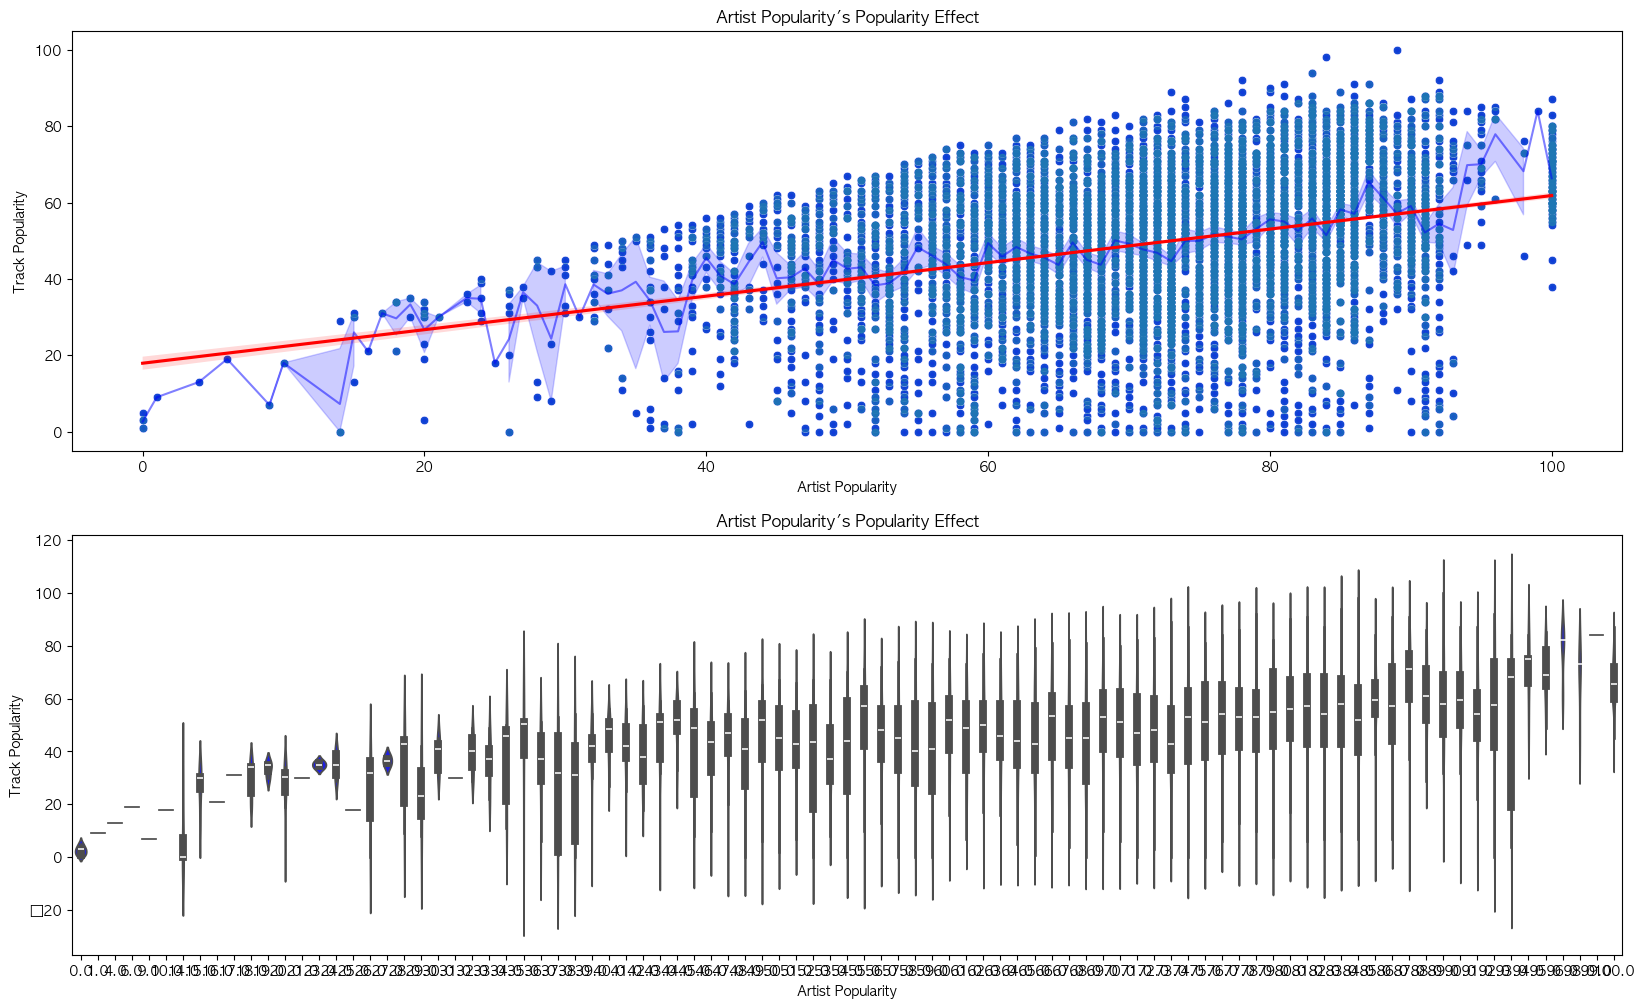

In [15]:
plt.figure(figsize=(20,12))
plt.rc('font', family='AppleGothic')
plt.subplot(2,1,1)
sns.scatterplot(x="artist_popularity", y="track_popularity", data=artist_popularity_df, color='blue')
sns.lineplot(x="artist_popularity", y="track_popularity", data=artist_popularity_df, color='blue', alpha = 0.5)
sns.regplot(x='artist_popularity', y='track_popularity', data=artist_popularity_df, 
            scatter_kws={'alpha':0.5, 's':20}, line_kws={'color':'red'})
plt.xlabel('Artist Popularity')
plt.ylabel('Track Popularity')
plt.title('Artist Popularity\'s Popularity Effect')

plt.subplot(2,1,2)
sns.violinplot(x="artist_popularity", y="track_popularity", data=artist_popularity_df, color='blue')
plt.xlabel('Artist Popularity')
plt.ylabel('Track Popularity')
plt.title('Artist Popularity\'s Popularity Effect')
plt.show()

## Hypothesis 2 : Previous Songs will impact on next song's Success

### 1. Objective
To investigate the existence of a "Momentum Effect" in the music industry. Specifically, we analyzed whether the popularity of an artist's **immediately preceding track** significantly predicts the success of their **current track**.

### 2. Data Processing
* **Feature Engineering:** A new variable, `prev_track_popularity`, was created by:
    1. Sorting the data by `release_date`.
    2. Grouping by `artist_id`.
    3. Shifting the `track_popularity` values by 1 to align the previous song's score with the current song.
* **Data Cleaning:** Rows with `NaN` values (the first song of every artist) were removed, resulting in a final sample size of **7,936 observations**.

In [16]:
track_popularity_df = track_df.sort_values(by=['release_date'], ignore_index=False)
track_popularity_df['prev_track_popularity'] = (
    track_popularity_df.groupby('artist_id')['track_popularity'].shift(1)
)
track_popularity_df = track_popularity_df.dropna(subset=['track_popularity', 'prev_track_popularity'])
track_popularity_df.head()

,track_name,artist_name,genre,duration,duration_ms,track_popularity,bpm,energy,brightness,noisiness,...,cover_art_url,artist_image_url,explicit,is_streamable,spotify_id,spotify_artist_id,artist_id,collection_id,track_id,prev_track_popularity
8594,White Christmas,The Drifters,R&B/Soul,2.669550,160173,78.0,123.046875,0.112107,1298.005407,0.045559,...,https://i.scdn.co/image/ab67616d0000b2732a8c6f...,https://i.scdn.co/image/9cebb08480116550d85b62...,False,True,72Z28IsvEVLjSWdUKEQgZ0,1FqqOl9itIUpXr4jZPIVoT,576693,64743610,64743236,78.0
7204,(There'll Be) Peace In the Valley (For Me),Elvis Presley,Rock,3.378533,202712,61.0,99.384014,0.094383,1473.404234,0.060671,...,https://i.scdn.co/image/ab67616d0000b273a2a6d5...,https://i.scdn.co/image/ab6761610000e5eb9a93e2...,False,True,7meT2kymrRK8w2lcB894ek,43ZHCT0cAZBISjO8DG9PnE,197443,217633715,217634233,54.0
3457,Ballad Of A Teenage Queen,Johnny Cash,Country,2.164450,129867,28.0,99.384014,0.201848,1851.692229,0.070068,...,https://i.scdn.co/image/ab67616d0000b273cbb4e4...,https://i.scdn.co/image/ab6761610000e5eb94a832...,False,False,5m9HvVMM1o4sO4MuWx2fyu,6kACVPfCOnqzgfEF5ryl0x,70936,251001680,251001821,16.0
3483,Ballad Of A Teenage Queen,Johnny Cash,Country,2.164450,129867,28.0,99.384014,0.201848,1851.692229,0.070068,...,https://i.scdn.co/image/ab67616d0000b273cbb4e4...,https://i.scdn.co/image/ab6761610000e5eb94a832...,False,False,5m9HvVMM1o4sO4MuWx2fyu,6kACVPfCOnqzgfEF5ryl0x,70936,251001680,251001821,28.0
7864,Too Much,Elvis Presley,Rock,2.580667,154840,38.0,117.453835,0.226855,2168.352066,0.097440,...,https://i.scdn.co/image/ab67616d0000b273a1a214...,https://i.scdn.co/image/ab6761610000e5eb9a93e2...,False,True,5MCLmWJgzC3wTptkENyntW,43ZHCT0cAZBISjO8DG9PnE,197443,388127843,388127918,61.0


### 3. Statistical Findings

In [17]:
pearson_r, pearson_p = pearsonr(
    track_popularity_df['prev_track_popularity'],
    track_popularity_df['track_popularity']
)

spearman_r, spearman_p = spearmanr(
    track_popularity_df['prev_track_popularity'],
    track_popularity_df['track_popularity']
)

print(f"pearson : r = {pearson_r:.3f}, p = {pearson_p:.3f}")
print(f"spearman : r = {spearman_r:.3f}, p = {spearman_p:.3f}")

pearson : r = 0.583, p = 0.000
spearman : r = 0.568, p = 0.000


In [18]:
X = track_popularity_df[['prev_track_popularity']]
X = sm.add_constant(X)
y = track_popularity_df['track_popularity']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     4091.
Date:                Wed, 31 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:55:09   Log-Likelihood:                -32591.
No. Observations:                7936   AIC:                         6.519e+04
Df Residuals:                    7934   BIC:                         6.520e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    18.68

**1. The Relationship is Statistically Significant ($P-Value < 0.05$)**

**2. Coefficient $\approx$ 0.44**
- Result: $coef = 0.6065$
- Equation: $$TrackPopularity=17.9+0.60(prev_track_popularity)$$
- For every 10 points an artist gains in previous track popularity, their following song automatically gains about 6 points in popularity, even before anyone listens to it.

**3. R-squared = 0.109**
- Result: $R^2 =0.340 (34%)$
- Previous Track's Popularity explains $\approx$ 34% of why a song is a hit.


**Previous Track's Success may imply MORE about track's success than Artist's Fame**

### 4. Visualization

/Users/lucyroh/Desktop/STUDY/Data Projects/00_music_analysis/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


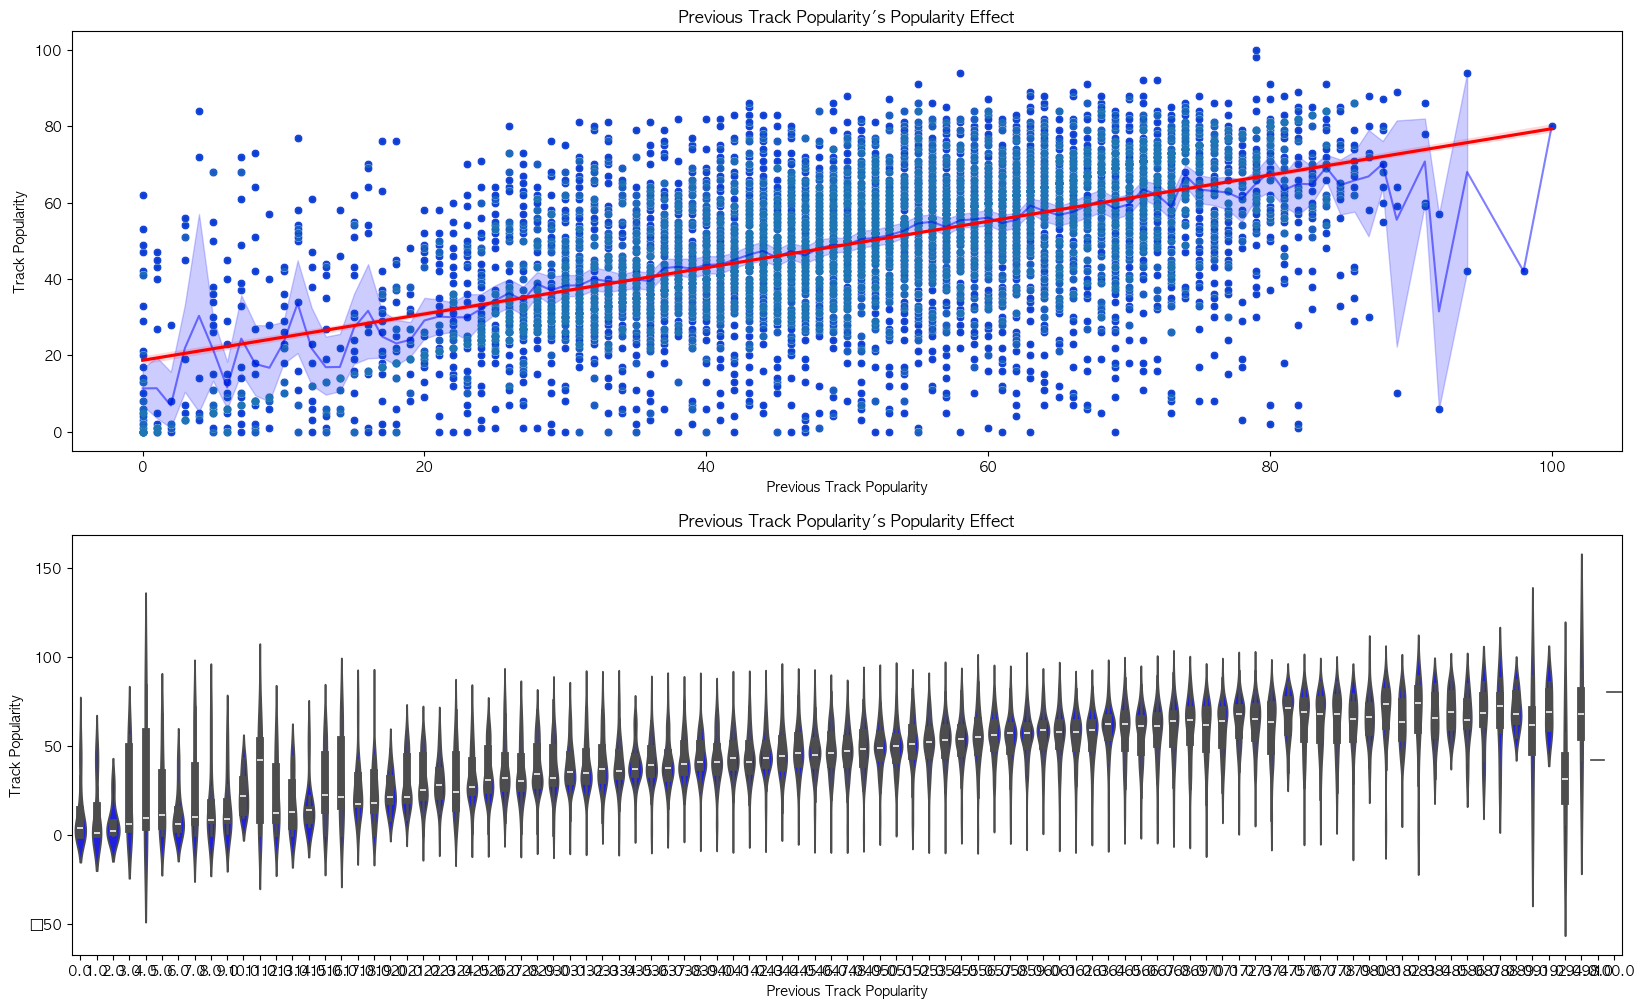

In [19]:
plt.figure(figsize=(20,12))
plt.rc('font', family='AppleGothic')
plt.subplot(2,1,1)
sns.scatterplot(x="prev_track_popularity", y="track_popularity", data=track_popularity_df, color='blue')
sns.lineplot(x="prev_track_popularity", y="track_popularity", data=track_popularity_df, color='blue', alpha = 0.5)
sns.regplot(x='prev_track_popularity', y='track_popularity', data=track_popularity_df, 
            scatter_kws={'alpha':0.5, 's':20}, line_kws={'color':'red'})
plt.xlabel('Previous Track Popularity')
plt.ylabel('Track Popularity')
plt.title('Previous Track Popularity\'s Popularity Effect')

plt.subplot(2,1,2)
sns.violinplot(x="prev_track_popularity", y="track_popularity", data=track_popularity_df, color='blue')
plt.xlabel('Previous Track Popularity')
plt.ylabel('Track Popularity')
plt.title('Previous Track Popularity\'s Popularity Effect')
plt.show()

## Hypothesis 3 : Genre's Imapct on Success

/var/folders/fv/hnh2s54s4h9_vv9q4x1rbdj40000gn/T/ipykernel_59462/1935264447.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_genre, x='track_popularity', y='genre', order=top_genres, palette="Set1")
/Users/lucyroh/Desktop/STUDY/Data Projects/00_music_analysis/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 250 (\N{LATIN SMALL LETTER U WITH ACUTE}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


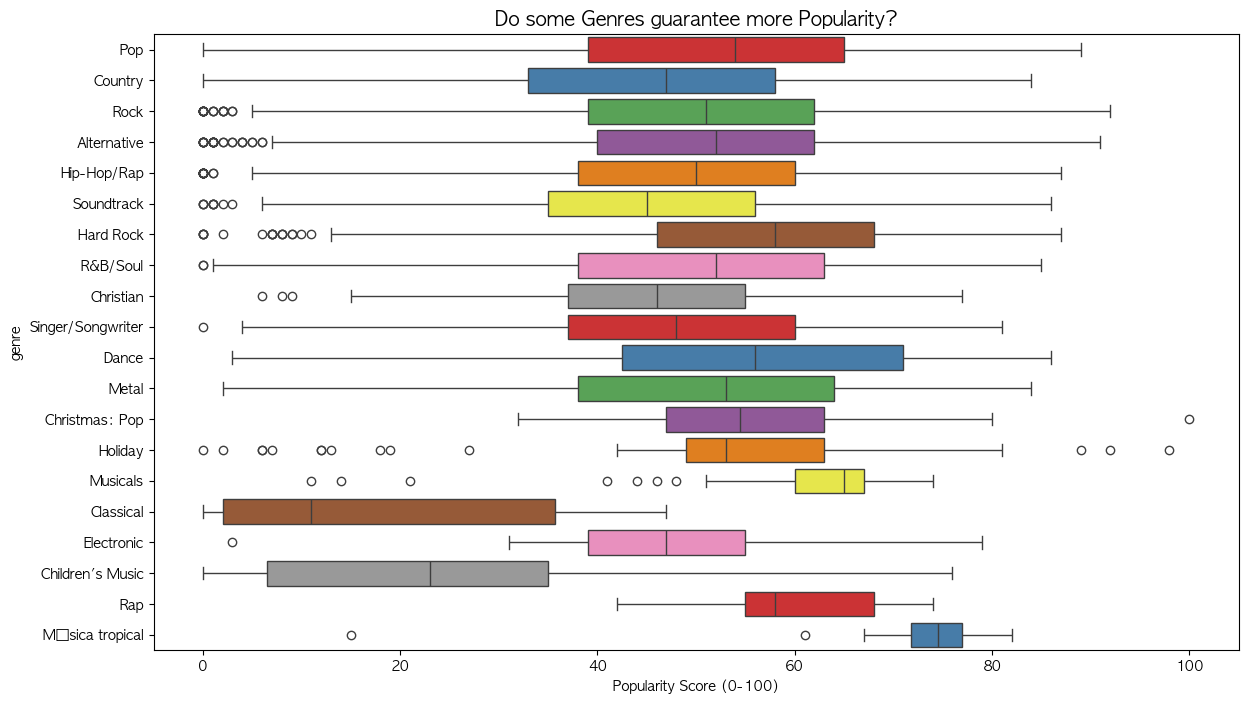

In [20]:
top_genres = track_df['genre'].value_counts().nlargest(20).index
df_genre = track_df[track_df['genre'].isin(top_genres)]


plt.figure(figsize=(14, 8))
sns.boxplot(data=df_genre, x='track_popularity', y='genre', order=top_genres, palette="Set1")
plt.title("Do some Genres guarantee more Popularity?", fontsize=14)
plt.xlabel("Popularity Score (0-100)")
plt.show()

In [21]:
from scipy import stats

groups = [df_genre[df_genre['genre'] == g]['track_popularity'] for g in top_genres]
f_val, p_val = stats.f_oneway(*groups)


print("H0 (Null Hypothesis): All genres have the same average popularity.")
print("H1 (Alternative): At least one genre is significantly different.)")
print("="*80)
print(f"ANOVA F-stat: {f_val:.2f}")
print(f"P-value: {p_val:.5f}")

if p_val < 0.05:
    print("Genre DOES significantly impact popularity.")
else:
    print("Genre does NOT significantly impact popularity.")

H0 (Null Hypothesis): All genres have the same average popularity.
H1 (Alternative): At least one genre is significantly different.)
ANOVA F-stat: 32.17
P-value: 0.00000
Genre DOES significantly impact popularity.


#### OLS Regression for top 20 Genres

In [22]:
genre_dummies = pd.get_dummies(df_genre['genre'], drop_first=True, dtype=int)

X = genre_dummies
y = df_genre['track_popularity']

# Add Constant (Intercept)
X = sm.add_constant(X)

model_genre = sm.OLS(y, X).fit()
print(model_genre.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     32.17
Date:                Wed, 31 Dec 2025   Prob (F-statistic):          1.78e-113
Time:                        22:55:12   Log-Likelihood:                -39994.
No. Observations:                9350   AIC:                         8.003e+04
Df Residuals:                    9330   BIC:                         8.017e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                50.1744      0.53

**1. Statistical Significance Varies by Genre (P−Value<0.05)**
- **Significant** (p<0.05): Música Tropical, Musicals, Rap, Classical, Children's Music, Hard Rock, Dance, Country.
- **Not Significant** (p>0.05): Metal, Rock, R&B/Soul, Electronic.
- For genres like Metal or Rock, the specific label does not statistically change the popularity compared to the baseline.

**2. Coefficients**
- **Highest** : Música Tropical ($coef=+21.87$)
$$TrackPopularity=50.17+21.87(if Tropical)$$
- If a song is categorized as "Música tropical," it gains nearly 22 points in predicted popularity.
- **Lowest** : Classical ($coef=−31.82$)
$$TrackPopularity=50.17−31.82(if Classical)$$
- Classifying a track as "Classical" penalizes its popularity score by ~32 points.
- Other Notable Shifts:
    - Musicals: +11.4 points
    - Rap: +9.6 points
    - Children's Music: −26.1 points

**3. R-squared = 0.061**
- Result: $R^2 =0.061 (6.1%)$
- Genre only explains ≈ 6% of the variance in popularity.

While specific genres (like Tropical) have huge individual impacts, knowing the genre alone is a weak predictor for the dataset as a whole compared to "Momentum" (34%).

**Genre acts as a specific "Modifier" (Bonus/Penalty) rather than a primary driver of success.**

## Analysis 4 : Audio Features

In [23]:
audio_cols = ['bpm', 'energy', 'brightness', 'noisiness', 'rhythm_strength']

X = track_df[audio_cols]
y = track_df['track_popularity']

X = sm.add_constant(X)

model_audio = sm.OLS(y, X).fit()
print(model_audio.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     23.98
Date:                Wed, 31 Dec 2025   Prob (F-statistic):           4.75e-24
Time:                        22:55:12   Log-Likelihood:                -41127.
No. Observations:                9544   AIC:                         8.227e+04
Df Residuals:                    9538   BIC:                         8.231e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              40.6703      1.353     

/Users/lucyroh/Desktop/STUDY/Data Projects/00_music_analysis/.venv/lib/python3.14/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.draw()
/Users/lucyroh/Desktop/STUDY/Data Projects/00_music_analysis/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


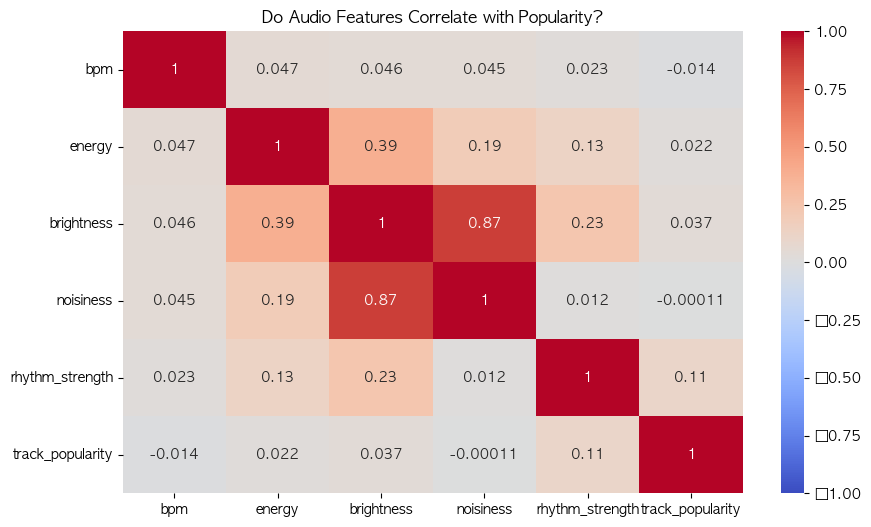

In [24]:
plt.figure(figsize=(10, 6))
sns.heatmap(track_df[audio_cols + ['track_popularity']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Do Audio Features Correlate with Popularity?")
plt.show()

- Strong Multicollinearity -> drop noisiness or brightness for prediction model

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

common_features = ['bpm', 'rhythm_strength']
target = 'track_popularity'

train_df, test_df = train_test_split(track_df, test_size=0.2, random_state=42)

y_train = train_df[target]
y_test = test_df[target]

X_train_A = train_df[common_features + ['brightness']]
X_test_A = test_df[common_features + ['brightness']]

model_A = LinearRegression()
model_A.fit(X_train_A, y_train)
pred_A = model_A.predict(X_test_A)
rmse_A = np.sqrt(mean_squared_error(y_test, pred_A))

# --- MODEL B: Using Noisiness ---
X_train_B = train_df[common_features + ['noisiness']]
X_test_B = test_df[common_features + ['noisiness']]

model_B = LinearRegression()
model_B.fit(X_train_B, y_train)
pred_B = model_B.predict(X_test_B)
rmse_B = np.sqrt(mean_squared_error(y_test, pred_B))

print(f"Model A (Brightness) RMSE: {rmse_A:.4f}")
print(f"Model B (Noisiness) RMSE:  {rmse_B:.4f}")

Model A (Brightness) RMSE: 17.9883
Model B (Noisiness) RMSE:  17.9979


- Choose Brightness

---

# Modeling - Popularity Prediction

In [26]:
df_combined = pd.merge(
    track_df,
    track_popularity_df[['track_id', 'prev_track_popularity']], 
    on='track_id', 
    how='left'
)

# If prev_track_pop is missing, fill it with the Artist's Popularity
df_combined['prev_track_popularity'] = df_combined['prev_track_popularity'].fillna(df_combined['artist_popularity'])
df_combined['prev_track_popularity'] = df_combined['prev_track_popularity'].fillna(0)

display(df_combined[['artist_name', 'artist_popularity', 'prev_track_popularity']].head())

,artist_name,artist_popularity,prev_track_popularity
0,Erick Sermon,53.0,55.0
1,Madonna,96.0,82.0
2,Journey,76.0,53.0
3,Jason Mraz,73.0,33.0
4,Erick Sermon,53.0,55.0


In [27]:
features = [
    'artist_popularity',
    'prev_track_popularity',
    'bpm', 
    'brightness',
    'rhythm_strength'
]
target = 'track_popularity'

top_genres = df_combined['genre'].value_counts().nlargest(20).index
df_final = df_combined[df_combined['genre'].isin(top_genres)].copy()

genre_dummies = pd.get_dummies(df_final['genre'], drop_first=True, dtype=int)

X = df_final[features]
X = pd.concat([X, genre_dummies], axis=1)
y = df_final[target]


X = sm.add_constant(X) # Add Intercept
final_model = sm.OLS(y, X).fit()

print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     272.2
Date:                Wed, 31 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:55:12   Log-Likelihood:                -45644.
No. Observations:               11196   AIC:                         9.134e+04
Df Residuals:                   11171   BIC:                         9.152e+04
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     5.07

In [28]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11196 entries, 0 to 11419
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   track_name             11196 non-null  object        
 1   artist_name            11196 non-null  object        
 2   genre                  11196 non-null  object        
 3   duration               11196 non-null  float64       
 4   duration_ms            11196 non-null  int64         
 5   track_popularity       11196 non-null  float64       
 6   bpm                    11196 non-null  float64       
 7   energy                 11196 non-null  float64       
 8   brightness             11196 non-null  float64       
 9   noisiness              11196 non-null  float64       
 10  rhythm_strength        11196 non-null  float64       
 11  artist_popularity      11196 non-null  float64       
 12  artist_followers       11196 non-null  float64       
 13  artist

In [29]:
correlation_matrix = df_final[features].corr()
display(correlation_matrix)

,artist_popularity,prev_track_popularity,bpm,brightness,rhythm_strength
artist_popularity,1.000000,0.317927,-0.010498,0.038695,0.111511
prev_track_popularity,0.317927,1.000000,-0.015815,0.043637,0.122307
bpm,-0.010498,-0.015815,1.000000,0.052403,0.015592
brightness,0.038695,0.043637,0.052403,1.000000,0.238167
rhythm_strength,0.111511,0.122307,0.015592,0.238167,1.000000


- Multicolinerity not a Problem -> Data Type?

In [30]:
top_genres = df_combined['genre'].value_counts().nlargest(15).index

df_final = df_combined[df_combined['genre'].isin(top_genres)].copy()

print(f"Original Rows: {len(df_combined)}")
print(f"Filtered Rows (Top 20 Genres): {len(df_final)}")

genre_dummies = pd.get_dummies(df_final['genre'], drop_first=True, dtype=int)

display(genre_dummies.head())

Original Rows: 11420
Filtered Rows (Top 20 Genres): 10936


,Christian,Christmas: Pop,Classical,Country,Dance,Hard Rock,Hip-Hop/Rap,Holiday,Metal,Pop,R&B/Soul,Rock,Singer/Songwriter,Soundtrack
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [31]:
features = ['artist_popularity', 'prev_track_popularity', 'bpm', 'brightness', 'rhythm_strength']
X = pd.concat([df_final[features], genre_dummies], axis=1)
display(X.head())

,artist_popularity,prev_track_popularity,bpm,brightness,rhythm_strength,Christian,Christmas: Pop,Classical,Country,Dance,Hard Rock,Hip-Hop/Rap,Holiday,Metal,Pop,R&B/Soul,Rock,Singer/Songwriter,Soundtrack
0,53.0,55.0,99.384014,1887.936273,2.063508,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,96.0,82.0,117.453835,2826.828547,2.087084,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,76.0,53.0,117.453835,2063.243547,1.150188,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,73.0,33.0,151.999081,1737.766877,1.706438,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,53.0,55.0,99.384014,1868.193043,2.053480,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [32]:
y = df_final['track_popularity']

X_ols = sm.add_constant(X)

final_model = sm.OLS(y, X_ols).fit()
print(final_model.summary())

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     321.7
Date:                Wed, 31 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:55:13   Log-Likelihood:                -44613.
No. Observations:               10936   AIC:                         8.927e+04
Df Residuals:                   10916   BIC:                         8.941e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     4.83

- Model Improved from $R^2\approx34%$ (Momentum only) to $R^2\approx35.9%$
- Still needs fixing (Standarsization for Genre Columns)

In [33]:
from sklearn.preprocessing import StandardScaler

num_cols = ['prev_track_popularity', 'bpm', 'brightness', 'rhythm_strength']

scaler = StandardScaler()

df_scaled = df_final.copy()
df_scaled[num_cols] = scaler.fit_transform(df_final[num_cols])

X_scaled = pd.concat([df_scaled[num_cols], genre_dummies], axis=1)
X_scaled = sm.add_constant(X_scaled)

final_model_scaled = sm.OLS(y, X_scaled).fit()
print(final_model_scaled.summary())
print(f"Condition Number: {final_model_scaled.condition_number:.2f}")

                            OLS Regression Results                            
Dep. Variable:       track_popularity   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     308.6
Date:                Wed, 31 Dec 2025   Prob (F-statistic):               0.00
Time:                        22:55:13   Log-Likelihood:                -44795.
No. Observations:               10936   AIC:                         8.963e+04
Df Residuals:                   10917   BIC:                         8.977e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    49.81

In [34]:
import joblib

prediction_model = LinearRegression()
prediction_model.fit(X_scaled.drop(columns='const'), y)
#drop const to prevent redundancy

model_package = {
    "model": prediction_model,
    "scaler": scaler,
    "features": X_scaled.columns.tolist(),
    "num_cols": num_cols
}

joblib.dump(model_package, "models/popularity_prediction_model.pkl")
print("✅ popularity_prediction_model saved")

✅ popularity_prediction_model saved


# Genre Matched Model

In [35]:
hits_df = df_final[df_final['track_popularity'] >= 70]

genre_best_features = hits_df.groupby('genre')[['bpm', 'brightness', 'rhythm_strength']].mean()

print("--- The Best Features for Each Genre ---")
display(genre_best_features)

--- The Best Features for Each Genre ---


,bpm,brightness,rhythm_strength
genre,,,
Alternative,111.786470,2101.873581,1.328693
Christian,110.764402,2428.091552,1.396140
Christmas: Pop,123.520523,2858.045652,1.624111
Country,118.065384,2165.133392,1.338933
Dance,123.832668,2647.844254,1.425512
Hard Rock,119.448746,2581.389867,1.232878
Hip-Hop/Rap,114.919309,2330.686264,1.757088
Holiday,110.762293,2005.017787,1.270765
Metal,118.955756,2761.193558,1.177336


In [36]:
from sklearn.tree import DecisionTreeClassifier, export_text

target_genre = 'Dance'
df_final['is_target'] = (df_final['genre'] == target_genre).astype(int)

tree = DecisionTreeClassifier(max_depth=3)
tree.fit(df_final[['bpm', 'brightness', 'rhythm_strength']], df_final['is_target'])

tree_rules = export_text(tree, feature_names=['bpm', 'brightness', 'rhythm_strength'])
print(f"--- Rules for {target_genre} ---")
print(tree_rules)

--- Rules for Dance ---
|--- brightness <= 3123.64
|   |--- rhythm_strength <= 2.23
|   |   |--- brightness <= 2629.86
|   |   |   |--- class: 0
|   |   |--- brightness >  2629.86
|   |   |   |--- class: 0
|   |--- rhythm_strength >  2.23
|   |   |--- bpm <= 73.98
|   |   |   |--- class: 1
|   |   |--- bpm >  73.98
|   |   |   |--- class: 0
|--- brightness >  3123.64
|   |--- brightness <= 3770.10
|   |   |--- bpm <= 120.25
|   |   |   |--- class: 0
|   |   |--- bpm >  120.25
|   |   |   |--- class: 0
|   |--- brightness >  3770.10
|   |   |--- brightness <= 3891.58
|   |   |   |--- class: 1
|   |   |--- brightness >  3891.58
|   |   |   |--- class: 0



In [37]:
model_package['genre_best_featueres'] = genre_best_features.to_dict(orient='index')

import joblib
joblib.dump(model_package, "spotify_model_package.pkl")

print("Genre_best_features_saved")

Genre_best_features_saved


# Genre Calssifier Model

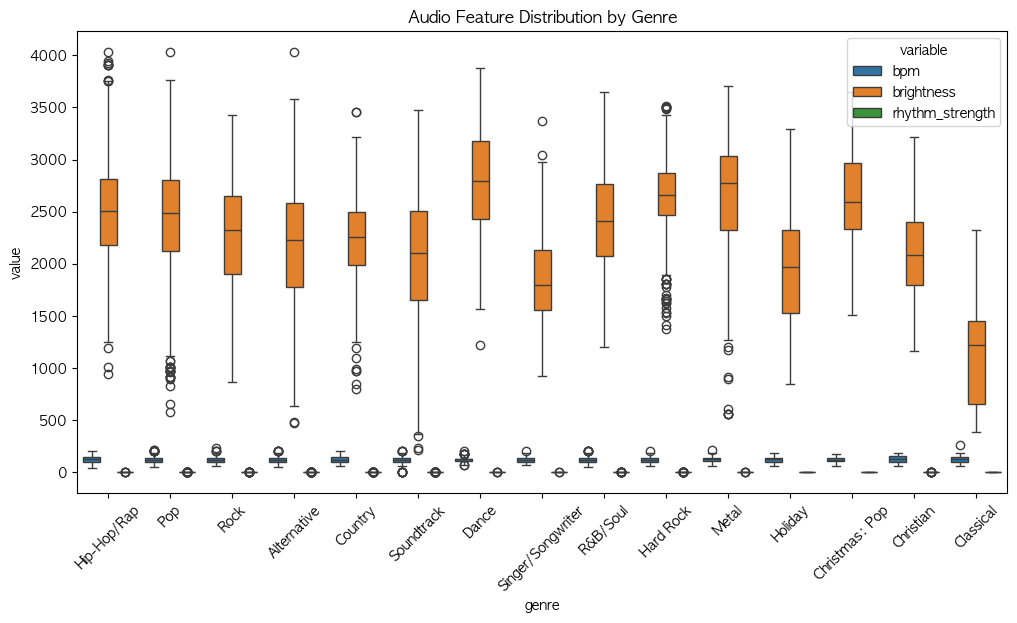

In [38]:
features_to_plot = ['bpm', 'brightness', 'rhythm_strength']
df_melted = df_final.melt(id_vars='genre', value_vars=features_to_plot)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_melted, x='genre', y='value', hue='variable')
plt.xticks(rotation=45)
plt.title("Audio Feature Distribution by Genre")
plt.show()

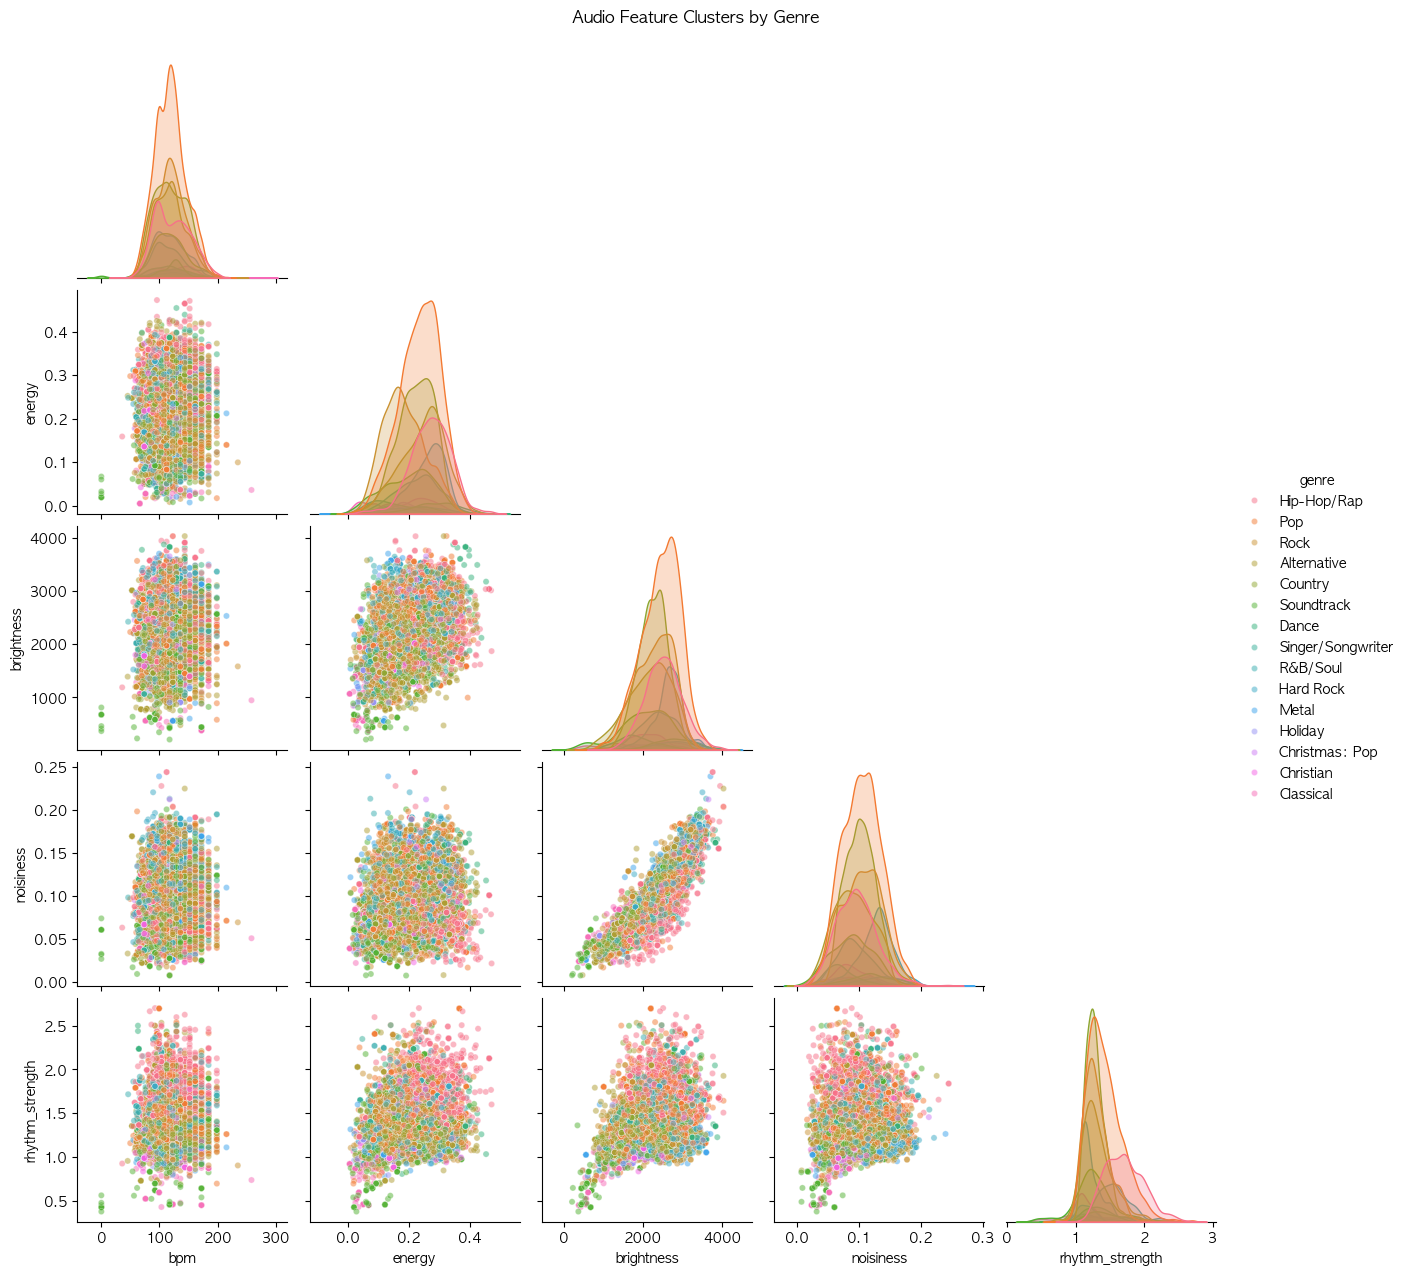

In [39]:
audio_cols = ['bpm', 'energy', 'brightness', 'noisiness', 'rhythm_strength']

sns.pairplot(df_final[audio_cols + ['genre']], 
             hue='genre', 
             corner=True, 
             plot_kws={'alpha': 0.5, 's': 20})

plt.suptitle("Audio Feature Clusters by Genre", y=1.02)
plt.show()

/Users/lucyroh/Desktop/STUDY/Data Projects/00_music_analysis/.venv/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


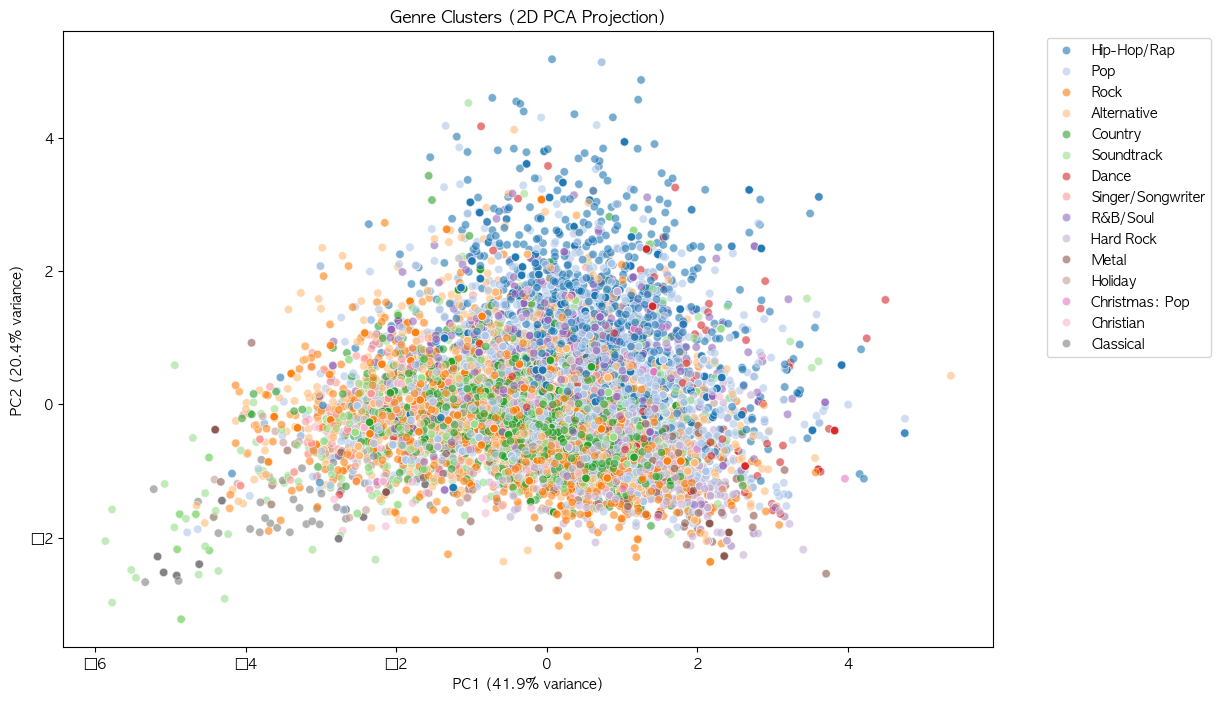

Total Variance Explained: 62.21%


In [40]:
from sklearn.decomposition import PCA

audio_cols = ['bpm', 'energy', 'brightness', 'noisiness', 'rhythm_strength']
X_audio = df_final[audio_cols]
X_scaled_pca = scaler.fit_transform(X_audio) # Using the scaler you already created

pca = PCA(n_components=2)
pca_results = pca.fit_transform(X_scaled_pca)

# 3. Create a DataFrame for plotting
df_pca = pd.DataFrame(data=pca_results, columns=['PC1', 'PC2'])
df_pca['genre'] = df_final['genre'].values

# 4. Plot the Clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='genre', alpha=0.6, palette='tab20')

plt.title("Genre Clusters (2D PCA Projection)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

print(f"Total Variance Explained: {sum(pca.explained_variance_ratio_):.2%}")

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# 1. Prepare the Tournament
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

results = {}

y_genre = df_final['genre']

print("--- Compare Classifier ---")
for name, model in models.items():
    cv_scores = cross_val_score(model, X_scaled_pca, y_genre, cv=5)
    results[name] = cv_scores.mean()
    print(f"{name}: {cv_scores.mean():.4f} accuracy")

# 3. Choose the Winner
best_classifier = max(results, key=results.get)
best_genre_model = models[best_classifier]
best_genre_model.fit(X_scaled_pca, y_genre) # Final fit on all data

print(f"\n Final Choice: {best_classifier}")

--- Compare Classifier ---
Random Forest: 0.3637 accuracy
Logistic Regression: 0.3302 accuracy
K-Nearest Neighbors: 0.2854 accuracy

 Final Choice: Random Forest


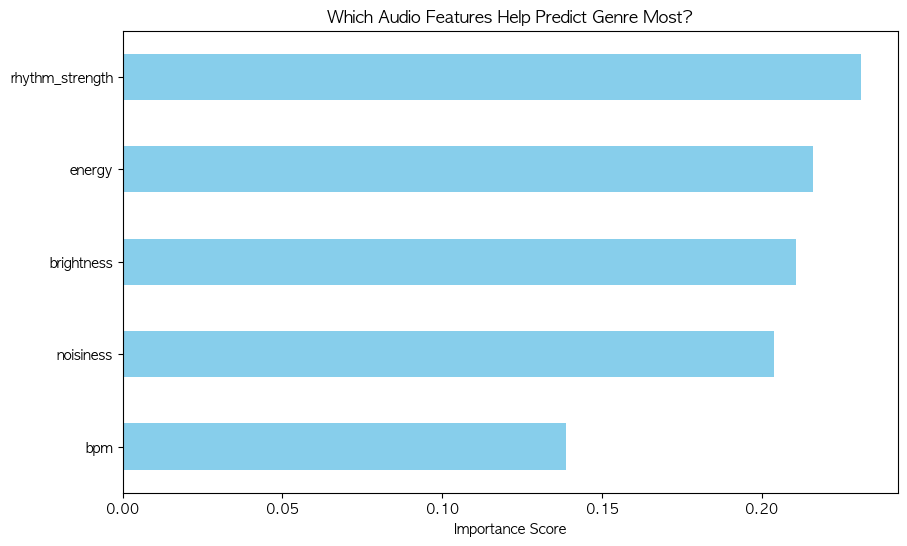

In [42]:
rf_final = RandomForestClassifier(n_estimators=100, random_state=42)
rf_final.fit(X_scaled_pca, y_genre) 

importances = pd.Series(rf_final.feature_importances_, index=audio_cols)
importances.sort_values().plot(kind='barh', color='skyblue', figsize=(10, 6))
plt.title("Which Audio Features Help Predict Genre Most?")
plt.xlabel("Importance Score")
plt.show()

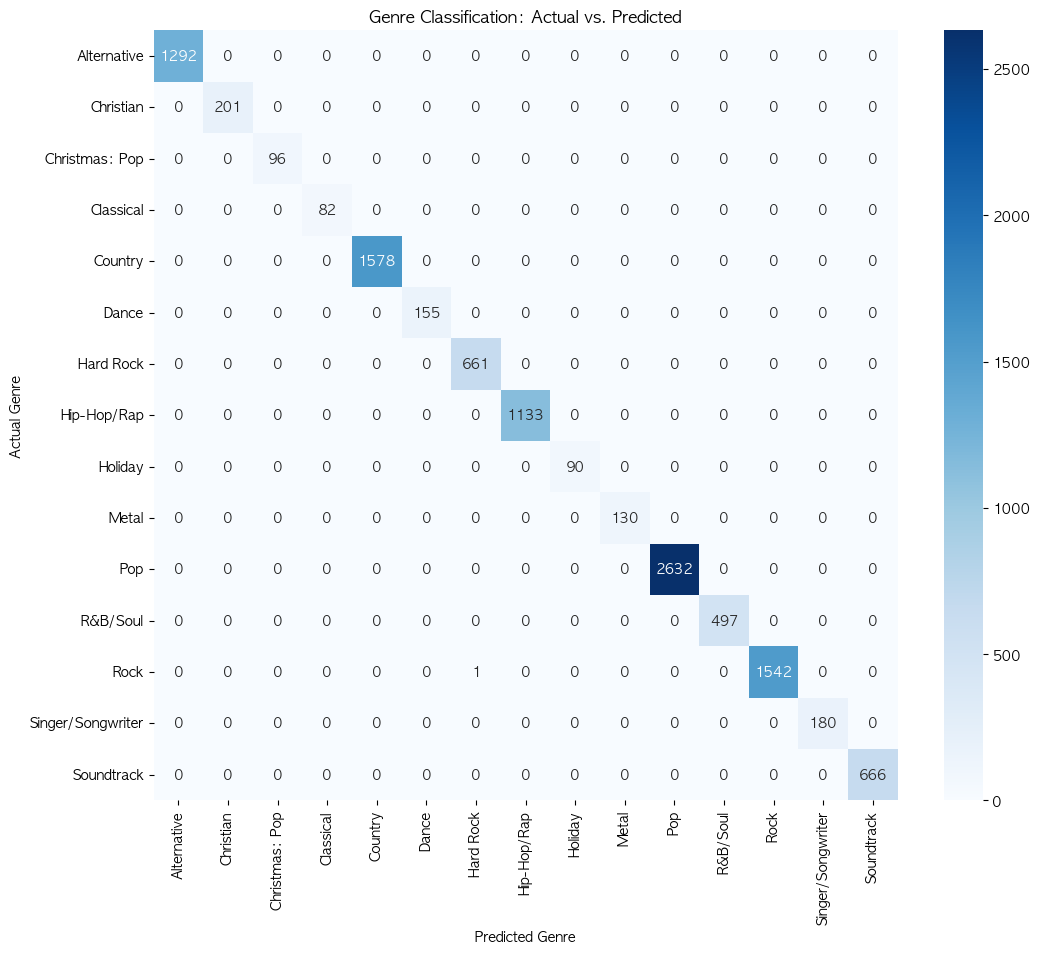

                   precision    recall  f1-score   support

      Alternative       1.00      1.00      1.00      1292
        Christian       1.00      1.00      1.00       201
   Christmas: Pop       1.00      1.00      1.00        96
        Classical       1.00      1.00      1.00        82
          Country       1.00      1.00      1.00      1578
            Dance       1.00      1.00      1.00       155
        Hard Rock       1.00      1.00      1.00       661
      Hip-Hop/Rap       1.00      1.00      1.00      1133
          Holiday       1.00      1.00      1.00        90
            Metal       1.00      1.00      1.00       130
              Pop       1.00      1.00      1.00      2632
         R&B/Soul       1.00      1.00      1.00       497
             Rock       1.00      1.00      1.00      1543
Singer/Songwriter       1.00      1.00      1.00       180
       Soundtrack       1.00      1.00      1.00       666

         accuracy                           1.00     1

In [43]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = rf_final.predict(X_scaled_pca)

plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_genre, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=rf_final.classes_, 
            yticklabels=rf_final.classes_)
plt.title("Genre Classification: Actual vs. Predicted")
plt.ylabel('Actual Genre')
plt.xlabel('Predicted Genre')
plt.show()

print(classification_report(y_genre, y_pred))

In [44]:
model_package['genre_model'] = rf_final

joblib.dump(model_package, "models/popularity_prediction_model.pkl")

['models/popularity_prediction_model.pkl']

In [46]:
track_df.to_csv("data/final_data.csv")